In [421]:
import base64
import json
import requests
import time, sys

from datetime import date
from IPython.display import clear_output
from matplotlib import pyplot

In [505]:
with open('config.json', 'r') as config:
    data = json.loads(config.read())
    SPOTIFY_CLIENT_ID = data['spotify_client_id']
    SPOTIFY_CLIENT_SECRET = data['spotify_client_secret']

SPOTIFY_AUTH_URL = "https://accounts.spotify.com/api/token"

def get_api_token():
    auth_string = f'{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}'.encode('utf-8')
    auth_encoded = base64.b64encode(auth_string).decode('utf-8')
    response = requests.post(SPOTIFY_AUTH_URL, data={
      'grant_type': 'client_credentials'  
    }, headers = {
        'Authorization': 'Basic {}'.format(auth_encoded)
    })
    return response.json()['access_token']

In [343]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [346]:
base_url = "https://playlist.cprnetwork.org/api/playlistCO/selectDate:{}"
# Dates are sent to the API in the following format yyyy-mm-dd (%Y-%m-%d) base64 encoded
june_dates = [date(2019, 6, i) for i in range(1, 31)]
july_dates = [date(2019, 7, i) for i in range(1, 31)]


def fetch_tracks(dates):
    tracks = []
    total = len(dates)
    for num, d in enumerate(dates):
        formatted = d.strftime('%Y-%m-%d').encode('utf-8')
        encoded = base64.b64encode(formatted).decode('utf-8')
        url = base_url.format(str(encoded))
        response = requests.get(url)
        tracks.extend(response.json())
        update_progress(num / (total -1))
    return tracks


In [347]:
july_tracks = fetch_tracks(july_dates)

Progress: [####################] 100.0%


In [387]:
def save_json(name, tracklist):
    # dont want to wait for the api again just save it
    with open(name, 'w') as f:
        f.write(json.dumps(tracklist))

def load_json(name):
    with open(name, 'r') as f:
        data = f.read()
        return json.loads(data)

In [405]:
print(f'june: {len(june_tracks)}')
print(f'july: {len(july_tracks)}')
# save_json('june.json', june_tracks)
# save_json('july.json', july_tracks)
july_tracks = load_json('july.json')
print(f'july: {len(july_tracks)}')

june: 11388
july: 10
july: 11262


In [396]:
spotify_url = "https://api.spotify.com/v1/search?"
def spotify_search(track, token):
    # q=album%3AHeartworms%20artist%3AThe%20Shins%20track%3A%20Name%20For%20You&type=track
    search_string = f"type=track&q=artist:{track['artist']} track:{track['title']}"
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer {}".format(token)
    }
    response = requests.get(spotify_url + search_string, headers=headers)
    return response.json()


In [406]:
def append_spotify_popularity(tracks): 
    errors = []
    total = len(tracks)
    token = get_api_token()
    for num, track in enumerate(tracks):
        if track.get('popularity', None) is None:
            result = spotify_search(track, token)
            try:
                track['popularity'] = result['tracks']['items'][0]['popularity']
            except (IndexError, KeyError) as e:
                errors.append({'track': track, 'error': e})
        update_progress(num / (total - 1))
    return tracks, errors

In [407]:
july_tracks, errors = append_spotify_popularity(july_tracks)
print(f'July Error Rate: {len(errors)/len(july_tracks)}')

Progress: [####################] 100.0%
July Error Rate: 0.08240099449476114


In [408]:
save_json('june.json', june_tracks)
save_json('july.json', july_tracks)

In [502]:
def draw_chart(t1, t2):
    p1 = []
    p2 = []
    for t in t1:
        p = t.get('popularity', False)
        if p:
            p1.append(p)
    for t in t2:
        p = t.get('popularity', False)
        if p:
            p2.append(p)
#     print(len(popularity))
#     print(len(tracks))
    n, bins, patches = pyplot.hist([p1,p2], bins=20)
    pyplot.ylabel('Track Count')
    pyplot.xlabel('Popularity')
    pyplot.show()

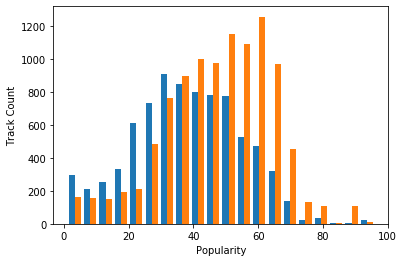

In [503]:
draw_chart(june_tracks, july_tracks)